In [13]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import re
import nltk
import time

In [14]:
# # importation du DATASET 
# from google.colab import files

# uploaded = files.upload()


In [15]:
df = pd.read_csv(r"C:\Users\kevin\0_projet_satisfaction_client\reviews_trust.csv")
df = df[["Commentaire", "star"]]
df["Sentiment"] = df["star"].apply(lambda x : np.where(x >=4 , 1 , 0)) # transformation du problème en classification binaire
df = df.dropna(axis = 0, how = 'any', subset =["Commentaire"])
df.reset_index(inplace = True)
df = df.drop('index', axis = 1)
initial_len = len(df)

# inital_distrib = list(df.Sentiment.value_counts())
# # sns.countplot(df.Sentiment)
# inital_distrib


In [16]:
df = df[["Commentaire","Sentiment"]]

def clean_exclamation(com) :  #suppression des points d'exclamation
    com = re.sub(r"\!", "", com)
    return (com)

def clean_interogation(com):  #suppression des points d'interrogation
    com = re.sub(r"\?", "", com)
    return (com)

def clean_etc(com):  #suppression des points de suspension
    com = re.sub(r"\.{2,}", "", com)
    return (com) 

df["Commentaire"]= df["Commentaire"].apply(lambda x : clean_exclamation(x))
df["Commentaire"]= df["Commentaire"].apply(lambda x : clean_interogation(x))
df["Commentaire"]= df["Commentaire"].apply(lambda x : clean_etc(x))

In [17]:
%%time
# découpage des commentaires sous forme de phrases
from nltk.tokenize import sent_tokenize

liste_comment  = []
for comment in df["Commentaire"]: 
    com = sent_tokenize(comment, language='french')
    liste_comment = liste_comment + com
    
len(liste_comment)

com_list = pd.DataFrame(liste_comment, columns=["Commentaire"])
com_list

# attribution des scores à chacunes des phrases

def attribution_score_com(Commentaire, score_com):
    score = []
    comment = sent_tokenize(Commentaire, language='french')
    sent_amount = len(comment)
    for i in range(sent_amount):
            score.append(score_com)
    return score

def attribution_score_df(df):
    score = []
    for ix in df.index :
        score = score + attribution_score_com(df["Commentaire"].loc[ix],df["Sentiment"].loc[ix])
    return score

Sentiment = pd.DataFrame(attribution_score_df(df), columns=["Sentiment"])
    #concaténation des deux dataframes
df = pd.concat([com_list,Sentiment], axis=1)

Wall time: 5.99 s


In [18]:
def findCAPSLOCK(com):  #compte le nombre de caractères en majuscule de chaque phrases
    r = re.compile(r"[A-Z]")
    capslock = r.findall(com)
    return len(capslock)

df["CAPSLOCK"]= df["Commentaire"].apply(lambda x : findCAPSLOCK(x))
df['nb_caracter'] = df["Commentaire"].apply(len)

from nltk.tokenize.regexp import RegexpTokenizer
tokenizer = RegexpTokenizer("[a-zA-Zéèçê]{2,}|[!?.]")
df["preprocessed"] = df["Commentaire"].apply(lambda x : " ".join(x.lower() for x in str(x).strip().split()))

# On remplace les éèê par e
def remplacement_carac_e(com):
    text=re.sub(r"[éèêë]","e",com)
    return text
df["preprocessed"] = df["preprocessed"].apply(lambda x : remplacement_carac_e(x))

def neg_identify(text): 
    text = tokenizer.tokenize(text)
    for pos, word in enumerate(text) :
        if pos != len(text)-1 :
            if (word == 'ne' or word == "n" or word =="n" or word == "pas"):
                text[pos+1] = "NON_"+text[pos+1]
    text = " ".join(text)
    return (text)
df["preprocessed"] = df["preprocessed"].apply(lambda x : neg_identify(x))

# Déclaration des stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
stop_words.update (["?","!","_",".",":",",",";","-","--","...","'","...","'",',',',','…la','la','le','les','..','…','(',')','a+','+','etc…','qq','``',"j'","j '"])
# après une première visualisation des données, "commande" est très freqement apparu dans les 2 catégories et n'apporte à priori pas d'information sur la satisfaction du client"
# print(stop_words)

# Definition d'une fonction de filtrage de stopwords
def stopwords_filtering(chaine): # fonction renvoyant une liste ne contenant pas les stopwords
    tokens =[]
    chaine = tokenizer.tokenize(chaine)
    for mot in chaine :
        if mot not in stop_words :#conservation des mots non stopwords 
            tokens.append(mot)
    tokens = " ".join(tokens)
    return tokens
df["preprocessed"] = df["preprocessed"].apply(lambda x : stopwords_filtering(x))

# Opération de stemming

from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
def  stemming(text) :
    text = tokenizer.tokenize(text)
    stemmed_text = ""
    for mot in text: 
        stem = stemmer.stem(mot)
        stemmed_text =  stemmed_text +" "+ stem
    return  stemmed_text

df["preprocessed"] = df["preprocessed"].apply(lambda x: stemming(x))

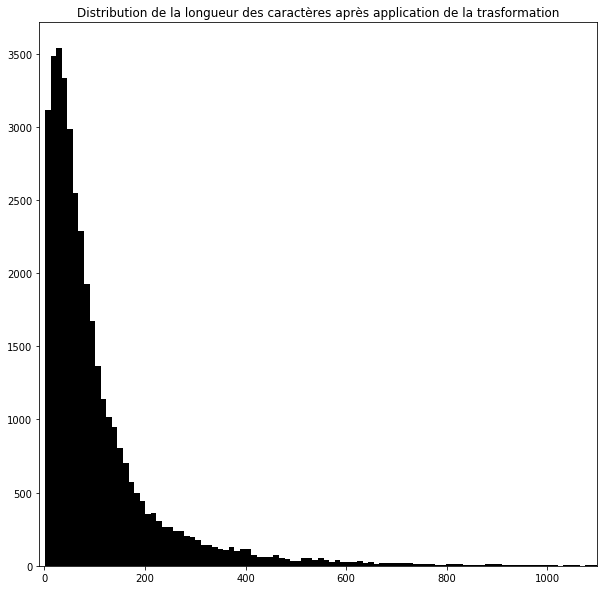

151.05764079527063

In [26]:
# sns.countplot(df.Sentiment)
# df.Sentiment.value_counts()
plt.figure(figsize=(10,10))
plt.hist(df.nb_caracter, bins = 500, color='k')
plt.title("Distribution de la longueur des caractères après application de la trasformation")
plt.xlim(-10,1100)
plt.show()
df.nb_caracter.std()

### Methode BOW (Bag of words) CountVectorizer

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

new_len = len(X)
new_distrib = list(y.value_counts(normalize= True))
print(new_distrib)

print(new_len, initial_len,new_len/initial_len)

[0.5847453111679455, 0.4152546888320546]
37536 19834 1.8925078148633658


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB #Particulièrement adapté aux problèmes de classification avec des features discretes (text classification)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [22]:
%%time
from scipy.sparse import hstack
# Vectorization avec CountVectorizer ()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# instanciation des classifieurs 
clf_reglog_unigram = LogisticRegression(C=1, max_iter= 10000)
#clf_svc_unigram = SVC()
#clf_MNB_unigram = MultinomialNB() 
clf_GB_unigram = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
start = time.time()
clf_reglog_unigram.fit(X_train, y_train)
end = time.time()
print("The time of clf_reglog_unigram:", end-start)
start = time.time()
#clf_svc_unigram.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_svc_unigram:", end-start)
#start = time.time()
#clf_MNB_unigram.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_MNB_unigram:", end-start)
start = time.time()
clf_GB_unigram.fit(X_train, y_train)
end = time.time()
print("The time of clf_GB_unigram:", end-start)




The time of clf_reglog_unigram: 0.4602336883544922
The time of clf_GB_unigram: 3.850930690765381
Wall time: 4.78 s


In [30]:
%%time
# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_unigram.score(X_test,y_test))
#print(" -- SVC --")
#print("Score sur le trainset :",clf_svc_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_unigram.score(X_test,y_test))
#print(" -- Multinomial Naïve Bayes --")
#print("Score sur le trainset :",clf_MNB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_unigram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_unigram.score(X_test,y_test))


# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog = clf_reglog_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog))
#print(" -- SVC --")
#pred_clf_svc = clf_svc_unigram.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_svc,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_svc))
#print(" -- Multinomial Naïve Bayes --")
#pred_clf_MNB = clf_MNB_unigram.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_MNB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_MNB))
print(" -- GradientBoosting -- ")
pred_clf_GB = clf_GB_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB))

 -- Régression logistique --
Score sur le trainset : 0.9039230051951512 ; Score sur le testset :  0.871470431539691
 -- GradientBoosting -- 
Score sur le trainset : 0.8271613161049687 ; Score sur le testset :  0.8332445391582313
 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,4022,410
1,555,2521


              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4432
           1       0.86      0.82      0.84      3076

    accuracy                           0.87      7508
   macro avg       0.87      0.86      0.87      7508
weighted avg       0.87      0.87      0.87      7508

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,3975,457
1,795,2281


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      4432
           1       0.83      0.74      0.78      3076

    accuracy                           0.83      7508
   macro avg       0.83      0.82      0.82      7508
weighted avg       0.83      0.83      0.83      7508

Wall time: 143 ms


In [23]:
df.head(1)

,Commentaire,Sentiment,CAPSLOCK,nb_caracter,preprocessed
0,"Bonjour , Ca doit faire 5 ans environ que je s...",0,2,71,bonjour ca doit fair an environ membr showroopr


### Interprétabilité BOW Régression logistique

In [31]:
import shap
features =  vec_unigram.get_feature_names() + ['CAPSLOCK','nb_caracter']
#Il faut voir 
explainer = shap.LinearExplainer(clf_reglog_unigram,X_train)
x = X_test.toarray()
x_test = pd.DataFrame(x, columns=features)
shap_values = explainer(x_test)
figure = plt.figure(figsize=(10,10))
shap.plots.beeswarm(shap_values,max_display=25)

ModuleNotFoundError: No module named 'numba.core'

In [32]:
%%time
X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

# Vectorization avec CountVectorizer ()

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)

#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# instanciation des classifieurs 
clf_reglog_ngram = LogisticRegression(C=1, max_iter= 10000)
#clf_svc_ngram = SVC()
#clf_MNB_ngram = MultinomialNB() 
clf_GB_ngram = GradientBoostingClassifier() 

# Fit des classifieurs aux données d'entraînement
start = time.time()
clf_reglog_ngram.fit(X_train, y_train)
end = time.time()
print("The time of clf_reglog_ngram:", end-start)
#start = time.time()
#clf_svc_ngram.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_svc_ngram:", end-start)
#start = time.time()
#clf_MNB_ngram.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_MNB_ngram:", end-start)
start = time.time()
clf_GB_ngram.fit(X_train, y_train)
end = time.time()
print("The time of clf_GB_ngram:", end-start)

The time of clf_reglog_ngram: 1.1709911823272705
The time of clf_GB_ngram: 14.386984586715698
Wall time: 16.7 s


In [33]:
%%time
# Affichage des scores des différents classifieurs
print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_ngram.score(X_test,y_test))
#print(" -- SVC --")
#print("Score sur le trainset :",clf_svc_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_ngram.score(X_test,y_test))
#print(" -- Multinomial Naïve Bayes --")
#print("Score sur le trainset :",clf_MNB_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_ngram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_ngram.score(X_test,y_test))



 -- Régression logistique --
Score sur le trainset : 0.9762221926202211 ; Score sur le testset :  0.8817261587639851
 -- GradientBoosting -- 
Score sur le trainset : 0.8293592646862928 ; Score sur le testset :  0.8321790090570058
Wall time: 74.8 ms


In [34]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog_ngram = clf_reglog_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_reglog_ngram))
#print(" -- SVC --")
#pred_clf_svc_ngram = clf_svc_ngram.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_svc_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_svc_ngram))
#print(" -- Multinomial Naïve Bayes --")
#pred_clf_MNB_ngram = clf_MNB_ngram.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_MNB_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_MNB_ngram))
print(" -- GradientBoosting -- ")
pred_clf_GB_ngram = clf_GB_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB_ngram))

 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,4119,313
1,575,2501


 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,3967,465
1,795,2281


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      4432
           1       0.83      0.74      0.78      3076

    accuracy                           0.83      7508
   macro avg       0.83      0.82      0.82      7508
weighted avg       0.83      0.83      0.83      7508

Wall time: 48.8 ms


In [17]:
##  Algorithmes de classification : tunning des hyperparamètres 

In [18]:
### Mise au point du modèle Multinomial Naïve Bayes (prenant en compte uniquement des unigrams)

In [19]:
%%time

from scipy.sparse import hstack
# Vectorization avec CountVectorizer ()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.model_selection import GridSearchCV
params = {"alpha": np.linspace(1e-10,1,20)}
grid_MN = GridSearchCV(MultinomialNB(), cv= 5, param_grid = params)
grid_MN.fit(X_train, y_train)
print("Meilleur paramètre : ", grid_MN.best_params_, "permettant d'obtenir un score de " , grid_MN.best_score_)
print("Score sur le trainset :",grid_MN.score(X_train,y_train),"; Score sur le testset : ",grid_MN.score(X_test,y_test))
print("On ne fait à priori pas face à un problème d'overfiting")


Meilleur paramètre :  {'alpha': 0.05263157904210526} permettant d'obtenir un score de  0.8388174689590177
Score sur le trainset : 0.8892034101505262 ; Score sur le testset :  0.851092168353756
On ne fait à priori pas face à un problème d'overfiting
Wall time: 3.17 s


In [20]:
pred_MNB = grid_MN.predict(X_test)
pred_proba_MNB = grid_MN.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_MNB[:,1], pos_label= 1)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();

print(classification_report(y_test, pred_MNB))

NameError: name 'y_pred_MNB' is not defined

In [ ]:
### Mise au point du modèle Multinomial Naïve Bayes (prenant en compte des unigrams et bigrams)

In [21]:
%%time 

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

# Vectorization avec CountVectorizer ()

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)

#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


params = {"alpha": np.linspace(1e-10,1,20)}
grid_MN_ngram = GridSearchCV(MultinomialNB(), cv= 5, param_grid = params)
grid_MN_ngram.fit(X_train, y_train)
print("Meilleur paramètre : ", grid_MN_ngram.best_params_, "permettant d'obtenir un score de " , grid_MN_ngram.best_score_)
print("Score sur le trainset :",grid_MN_ngram.score(X_train,y_train),"; Score sur le testset : ",grid_MN_ngram.score(X_test,y_test))
print("On fait probablement face à un problème d'overfiting")



Meilleur paramètre :  {'alpha': 1.0} permettant d'obtenir un score de  0.8417813660111746
Score sur le trainset : 0.9344611695750633 ; Score sur le testset :  0.8641449120937666
On fait probablement face à un problème d'overfiting
Wall time: 8.01 s


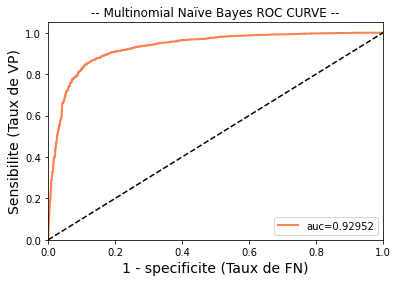

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4432
           1       0.87      0.79      0.83      3076

    accuracy                           0.86      7508
   macro avg       0.86      0.85      0.86      7508
weighted avg       0.86      0.86      0.86      7508



In [22]:
pred_MNB_ngram = grid_MN_ngram.predict(X_test)

pred_proba_MNB_ngram = grid_MN_ngram.predict_proba(X_test)

from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, pred_proba_MNB_ngram[:,1], pos_label= 1)
aucf= auc(fpr, tpr)
plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();

print(classification_report(y_test, pred_MNB_ngram))

In [ ]:
### Mise au point du modèle Regression logistique (prenant en compte uniquement des unigrams)

In [23]:
%%time


# Vectorization avec CountVectorizer ()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# define models and parameters
model = LogisticRegression(max_iter= 500)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
C = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=C)
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_lr = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_lr.best_score_, grid_lr.best_params_))
means = grid_lr.cv_results_['mean_test_score']
stds = grid_lr.cv_results_['std_test_score']
params = grid_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Score sur le trainset :",grid_lr.score(X_train,y_train),"; Score sur le testset : ",grid_lr.score(X_test,y_test))

Best: 0.859898 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.846743 (0.004390) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.846743 (0.004390) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.846677 (0.004314) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.854736 (0.005131) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.854736 (0.005131) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.854736 (0.005131) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.859864 (0.006390) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.859898 (0.006377) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.859898 (0.006425) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.846344 (0.005930) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.846344 (0.005930) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.846344 (0.005901) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.783136 (0.007053) wit

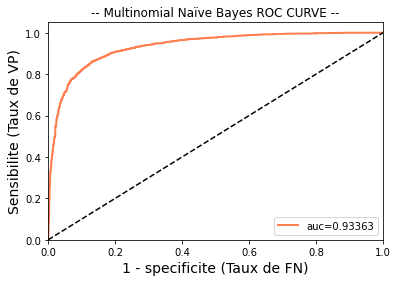

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4432
           1       0.85      0.82      0.83      3076

    accuracy                           0.87      7508
   macro avg       0.86      0.86      0.86      7508
weighted avg       0.87      0.87      0.87      7508



In [24]:
pred_lr = grid_lr.predict(X_test)

pred_proba_lr= grid_lr.predict_proba(X_test)

from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, pred_proba_lr[:,1], pos_label= 1)
aucf= auc(fpr, tpr)
plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();

print(classification_report(y_test, pred_lr))

###  Mise au point du modèle GradientBoosting (prenant en compte uniquement des unigrams)

In [25]:
%%time
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

# Vectorization avec CountVectorizer ()

vec_unigram_GB = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram_GB.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram_GB.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# define models and parameters
param = {"subsample": np.arange(0.6,0.9,0.1)}
# define grid search
model = GradientBoostingClassifier(learning_rate=0.1,n_estimators= 71, max_depth= 13, max_features='sqrt',min_samples_split= 60,min_samples_leaf=20)
grid_search = GridSearchCV(estimator=model,param_grid = param,  n_jobs=-1, cv=5, scoring='accuracy')
grid_gb = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_gb.best_score_, grid_gb.best_params_))
means = grid_gb.cv_results_['mean_test_score']
stds = grid_gb.cv_results_['std_test_score']
params = grid_gb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Score sur le trainset :",grid_gb.score(X_train,y_train),"; Score sur le testset : ",grid_gb.score(X_test,y_test))  



Best: 0.833422 using {'subsample': 0.7}
0.832123 (0.003021) with: {'subsample': 0.6}
0.833422 (0.004197) with: {'subsample': 0.7}
0.832623 (0.003526) with: {'subsample': 0.7999999999999999}
0.832457 (0.005130) with: {'subsample': 0.8999999999999999}
Score sur le trainset : 0.8356866924204076 ; Score sur le testset :  0.8372402770378263
Wall time: 24.7 s


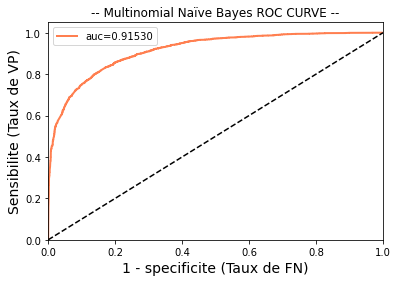

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4432
           1       0.82      0.77      0.80      3076

    accuracy                           0.84      7508
   macro avg       0.83      0.83      0.83      7508
weighted avg       0.84      0.84      0.84      7508



In [26]:
pred_gb_proba = grid_gb.predict_proba(X_test)
pred_gb = grid_gb.predict(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, pred_gb_proba[:,1], pos_label= 1)
aucf= auc(fpr, tpr)
plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();

print(classification_report(y_test, pred_gb))

In [ ]:
###  Mise au point du modèle SVC (prenant en compte uniquement des unigrams)

In [ ]:
%%time

# Vectorization avec CountVectorizer ()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# define models and parameters
model = SVC()
kernel = ['linear','poly', 'rbf', 'sigmoid']
gamma = ['scale']
C = [1,10,20,30,40,50]
grid = dict(kernel=kernel,C=C,gamma=gamma)
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_svc = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))
means = grid_svc.cv_results_['mean_test_score']
stds = grid_svc.cv_results_['std_test_score']
params = grid_svc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


print("Score sur le trainset :",grid_svc.score(X_train,y_train),"; Score sur le testset : ",grid_svc.score(X_test,y_test))

## Methode TF-IDF

In [35]:
%%time
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)
# Vectorization avec CountVectorizer ()

vec_unigram_tfidf = TfidfVectorizer( ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram_tfidf.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram_tfidf.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# instanciation des classifieurs 
clf_reglog_unigram = LogisticRegression(C=1, max_iter= 10000)
#clf_svc_unigram = SVC()
#clf_MNB_unigram = MultinomialNB() 
clf_GB_unigram = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
start = time.time()
clf_reglog_unigram.fit(X_train, y_train)
end = time.time()
print("The time of clf_reglog_unigram:", end-start)
#start = time.time()
#clf_svc_unigram.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_svc_unigram:", end-start)
#start = time.time()
#clf_MNB_unigram.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_MNB_unigram:", end-start)
start = time.time()
clf_GB_unigram.fit(X_train, y_train)
end = time.time()
print("The time of clf_GB_unigram:", end-start)


The time of clf_reglog_unigram: 0.17993855476379395
The time of clf_GB_unigram: 8.536754846572876
Wall time: 9.18 s


In [36]:
%%time
# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_unigram.score(X_test,y_test))
#print(" -- SVC --")
#print("Score sur le trainset :",clf_svc_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_unigram.score(X_test,y_test))
#print(" -- Multinomial Naïve Bayes --")
#print("Score sur le trainset :",clf_MNB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_unigram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_unigram.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9090848541361396 ; Score sur le testset :  0.8770644645711241
 -- GradientBoosting -- 
Score sur le trainset : 0.8299254029572399 ; Score sur le testset :  0.8337773042088439
Wall time: 67.8 ms


In [29]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog = clf_reglog_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog))
#print(" -- SVC --")
#pred_clf_svc = clf_svc_unigram.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_svc,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_svc))
#print(" -- Multinomial Naïve Bayes --")
#pred_clf_MNB_unigram = clf_MNB_unigram.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_MNB_unigram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_MNB_unigram))
print(" -- GradientBoosting -- ")
pred_clf_GB_unigram = clf_GB_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB_unigram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB_unigram))

 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,4060,372
1,588,2488


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4432
           1       0.87      0.81      0.84      3076

    accuracy                           0.87      7508
   macro avg       0.87      0.86      0.87      7508
weighted avg       0.87      0.87      0.87      7508

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,3968,464
1,810,2266


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      4432
           1       0.83      0.74      0.78      3076

    accuracy                           0.83      7508
   macro avg       0.83      0.82      0.82      7508
weighted avg       0.83      0.83      0.83      7508

Wall time: 151 ms


## Interprétabilité TF-IDF regression logistique 

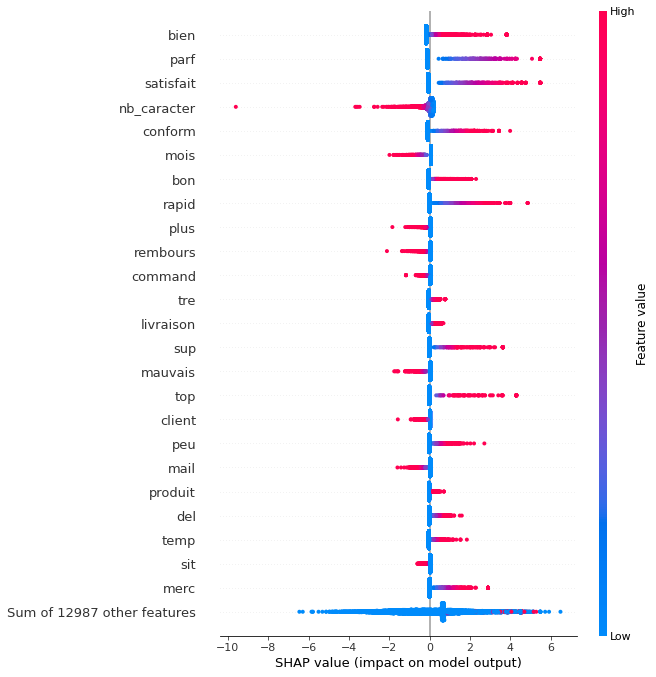

In [30]:
import shap
features =  vec_unigram_tfidf.get_feature_names() + ['CAPSLOCK','nb_caracter']
explainer = shap.LinearExplainer(clf_reglog_unigram,X_train)
x = X_test.toarray()
x_test = pd.DataFrame(x, columns=features)
shap_values = explainer(x_test)
figure = plt.figure(figsize=(10,10))
shap.plots.beeswarm(shap_values,max_display=25)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB #Particulièrement adapté aux problèmes de classification avec des features discretes (text classification)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

X = df.drop(['Commentaire', 'Sentiment'], axis=1)
y = df["Sentiment"]
df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)
# Vectorization avec CountVectorizer ()

vec_ngram_tfidf = TfidfVectorizer( ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram_tfidf.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram_tfidf.transform(df_test.preprocessed)
#on ajoute les metadonnées à notre vecteur d'occurence
X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# instanciation des classifieurs 
clf_reglog = LogisticRegression(C=1, max_iter= 5000)
#clf_svc = SVC()
#clf_MNB= MultinomialNB() 
clf_GB = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
# Fit des classifieurs aux données d'entraînement
start = time.time()
clf_reglog.fit(X_train, y_train)
end = time.time()
print("The time of clf_reglog:", end-start)
#start = time.time()
#clf_svc.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_svc:", end-start)
#start = time.time()
#clf_MNB.fit(X_train, y_train)
#end = time.time()
#print("The time of clf_MNB:", end-start)
start = time.time()
clf_GB.fit(X_train, y_train)
end = time.time()
print("The time of clf_GB:", end-start)



The time of clf_reglog: 2.689436674118042
The time of clf_GB: 54.27645492553711


In [32]:
%%time
# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog.score(X_train,y_train),"; Score sur le testset : ",clf_reglog.score(X_test,y_test))
#print(" -- SVC --")
#print("Score sur le trainset :",clf_svc.score(X_train,y_train),"; Score sur le testset : ",clf_svc.score(X_test,y_test))
#print(" -- Multinomial Naïve Bayes --")
#print("Score sur le trainset :",clf_MNB.score(X_train,y_train),"; Score sur le testset : ",clf_MNB.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB.score(X_train,y_train),"; Score sur le testset : ",clf_GB.score(X_test,y_test))


# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog = clf_reglog.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog))
#print(" -- SVC --")
#pred_clf_svc = clf_svc.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_svc,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_svc))
#print(" -- Multinomial Naïve Bayes --")
#pred_clf_MNB = clf_MNB.predict(X_test)
#display(pd.crosstab(y_test, pred_clf_MNB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
#print(classification_report(y_test,pred_clf_MNB))
print(" -- GradientBoosting -- ")
pred_clf_GB = clf_GB.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB))

 -- Régression logistique --
Score sur le trainset : 0.9744571733049154 ; Score sur le testset :  0.8799946723494939
 -- GradientBoosting -- 
Score sur le trainset : 0.8310576794991341 ; Score sur le testset :  0.8341768779968034
 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,4116,316
1,585,2491


              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4432
           1       0.89      0.81      0.85      3076

    accuracy                           0.88      7508
   macro avg       0.88      0.87      0.87      7508
weighted avg       0.88      0.88      0.88      7508

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,4058,374
1,871,2205


              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4432
           1       0.85      0.72      0.78      3076

    accuracy                           0.83      7508
   macro avg       0.84      0.82      0.82      7508
weighted avg       0.84      0.83      0.83      7508

Wall time: 292 ms
